In [1]:
using DelaySSAToolkit, Catalyst
using Test,BenchmarkTools

In [2]:
rn = @reaction_network begin
    1/(1+Y^2), 0 --> X
    1/(1+Y),   Y --> 0
end
jumpsys = convert(JumpSystem, rn, combinatoric_ratelaws = false)

Model ##ReactionSystem#257 with 2 equations
States (2):
  X(t)
  Y(t)
Parameters (0):

In [5]:
u0 = [0,0]
de_chan0 = [[]]
tf = 400.
tspan = (0,tf)
τ = 20.
dprob = DiscreteProblem(jumpsys, u0, tspan)

DiscreteProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 400.0)
u0: 2-element Vector{Int64}:
 0
 0

In [4]:
delay_trigger_affect! = function (integrator, rng)
    append!(integrator.de_chan[1], τ)
  end
  delay_trigger = Dict(1=>delay_trigger_affect!)
  delay_complete = Dict(1=>[2=>1, 1=>-1], 2=>[2=>1])
  delay_interrupt = Dict()
  delayjumpset = DelayJumpSet(delay_trigger, delay_complete, delay_interrupt)

DelayJumpSet(Dict{Int64, Any}(1 => var"#9#10"()), Dict{Int64, Any}(2 => [2 => 1], 1 => [2 => 1, 1 => -1]), Dict{Int64, Any}(), [1], Int64[])

In [8]:
medianlist=[]
algo_list =[DelayDirect(),DelayRejection(),DelayMNRM(),DelayDirectCR()]
for algo in algo_list
    djprob = DelayJumpProblem(jumpsys, dprob,algo,delayjumpset, de_chan0, save_positions=(false,false))
    a=@benchmark solve(djprob, SSAStepper())
    push!(medianlist,median(a).time/1e9)
end
medianlist

4-element Vector{Any}:
 0.0009453
 0.0027376
 0.003361
 0.0035119

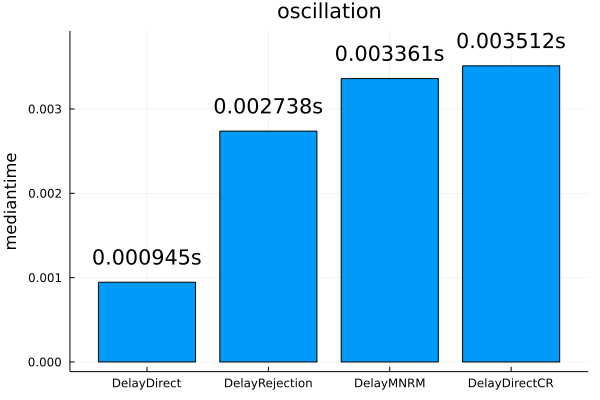

In [12]:
using Plots
medianvalue=[string(round(mt,digits=6),"s") for mt in medianlist]
algo_name = ["DelayDirect","DelayRejection","DelayMNRM","DelayDirectCR"]
p1=bar(algo_name,medianlist,legend=:false,title="oscillation",ylabel="mediantime")
scatter!(algo_name, 0.0003 .+ medianlist , markeralpha=0, series_annotations=medianvalue)